# IMPORTS

In [59]:
import json
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
import sys
import types
import os

custom_leiden_res = 0.9
apply_scaling = False

# LOAD + PREPROCESS
## functions

In [78]:
def load_lukassen():
    os.chdir("/Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/Charité/05_sorted/18_soupX_try/08_DEanalysis")

    with open("../02_mapped_gene_markers/exclusive_gene_markers.json", "r") as f:
    #with open("../02_mapped_gene_markers/all_gene_markers.json", "r") as f:
        marker_genes = json.load(f)

    pyEDs = sc.read_h5ad("../04_soup/pyED_correct_soupx.h5ad")
    pyED = sc.read_h5ad("../../data/pyED_correct.h5ad")

    json_marker_cell_types = list(marker_genes.keys())
    print(marker_genes)

    return (pyED, pyEDs, marker_genes, json_marker_cell_types)

In [79]:
def preprocess_datasets(pyED, pyEDs, leiden_res=0.2):
    """
    Preprocess both datasets: filter, normalize, log transform, PCA, neighbors, UMAP, Leiden clustering, and PAGA.
    Returns preprocessed copies of the datasets.
    """
    print("PREPROCESSING DATASETS...")
    pyED_copy = pyED.copy()
    pyEDs_copy = pyEDs.copy()

    # Process pyED (no soup correction)
    print("  Processing pyED...")
    sc.pp.filter_genes(pyED_copy, min_counts=1)
    sc.pp.normalize_total(pyED_copy, target_sum=1e4)
    sc.pp.log1p(pyED_copy)
    if apply_scaling:
        print("  Scaling pyED...")
        sc.pp.scale(pyED_copy, max_value=10)
    sc.tl.pca(pyED_copy, n_comps=50, svd_solver="arpack")
    sc.pp.neighbors(pyED_copy, n_neighbors=50, n_pcs=50, method="umap")
    sc.tl.umap(
        pyED_copy,
        min_dist=0.1,
        spread=0.6,
        n_components=2,
        random_state=42,
    )
    sc.tl.leiden(pyED_copy, resolution=leiden_res, flavor="igraph", n_iterations=2, directed=False, key_added="leiden_res")
    # PAGA for pyED
    #sc.tl.paga(pyED_copy, groups="leiden_res")
    #sc.pl.paga(pyED_copy, plot=False)  # compute positions
    #sc.tl.umap(pyED_copy, init_pos='paga')
    print("  ✓ pyED preprocessed with PAGA")

    # Process pyEDs (soup correction)
    print("  Processing pyEDs ...")
    sc.pp.filter_genes(pyEDs_copy, min_counts=1)
    sc.pp.normalize_total(pyEDs_copy, target_sum=1e4)
    sc.pp.log1p(pyEDs_copy)
    if apply_scaling:
        sc.pp.scale(pyEDs_copy, max_value=10)
    sc.tl.pca(pyEDs_copy, n_comps=50, svd_solver="arpack")
    #sc.pp.neighbors(pyEDs_copy, n_neighbors=35, n_pcs=35, method="umap")
    #sc.tl.umap(
    #    pyEDs_copy,
    #    min_dist=0.2,
    #    spread=1,
    #    n_components=2,
    #    random_state=42,
    #)
    sc.pp.neighbors(pyEDs_copy, n_neighbors=50, n_pcs=50, method="umap")  # fewer neighbors & gaussian kernel for more linear manifolds
    sc.tl.umap(
        pyEDs_copy,
        min_dist=0.1,      # smaller min_dist for tighter, more condensed paths
        spread=0.6,         # smaller spread to focus on narrow/linear structure
        n_components=2,
        random_state=42, 
        #negative_sample_rate=10   # encourages separating linear trajectories
    )
    sc.tl.leiden(pyEDs_copy, resolution=leiden_res, flavor="igraph", n_iterations=2, directed=False, key_added="leiden_res")
    
    print("PREPROCESSING COMPLETE!\n")
    return pyED_copy, pyEDs_copy


## run

In [141]:
# Load data
pyED, pyEDs, marker_genes, json_marker_cell_types = load_lukassen()

# Preprocess datasets (run this once, then reuse the preprocessed data)
pyED_processed, pyEDs_processed = preprocess_datasets(pyED, pyEDs, custom_leiden_res)


{'Early Sgonia': ['GFRA1', 'ID4', 'SOHLH1', 'SOHLH2', 'POU5F1', 'UCHL1', 'ITGB1', 'ITGA6', 'NGN3', 'SOX3', 'RET', 'LIN28A', 'ZBTB16', 'NOS2', 'EPCAM', 'BMI1'], 'Late Sgonia': ['DAZL', 'RAD51', 'STRA8', 'HIST1H1A', 'PCNA', 'TEX11', 'NANOS3', 'E2F1', 'HIST1H3A', 'WSB2', 'ESX1', 'USP26', 'SALL4', 'NLRP4C', 'CCNA2', 'CCNE2', 'CCND1', 'CRABP1', 'ESRP1', 'ADGRA3', 'CDKN1C', 'PER1', 'LIN28A', 'FIGLA', 'UTF1', 'HIST1H4M', 'FTHL17'], 'Early Scytes': ['DMC1', 'MEIOB', 'GPAT2'], 'Late Scytes': ['KDM3A', 'POU5F2'], 'Round Stids': ['SLX', 'HILS1', 'KLF17', 'CRISP2', 'AKAP4'], 'Later Stids': ['SUFU', 'DLL1', '1700024P04RIK', 'PRM1', 'DYRK4', 'TNP1', 'HSPA1L'], 'Sertoli': ['ID3', 'SOX8', 'RHOX5', 'TFCP2', 'WT1', 'GATA1', 'KITL'], 'Leydig': ['CYP17A1', 'HSD17B11', 'CSF1', 'VCAM1', 'HSD3B6']}
PREPROCESSING DATASETS...
  Processing pyED...
  ✓ pyED preprocessed with PAGA
  Processing pyEDs ...
PREPROCESSING COMPLETE!



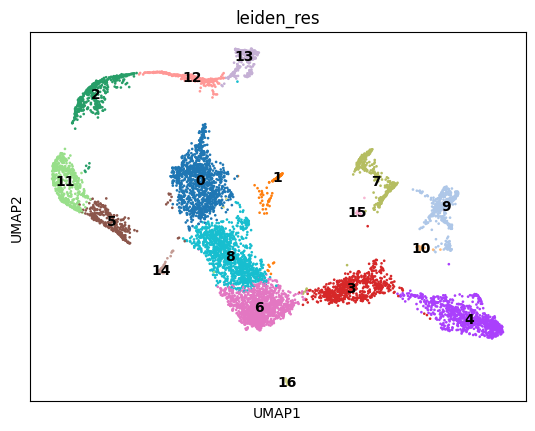

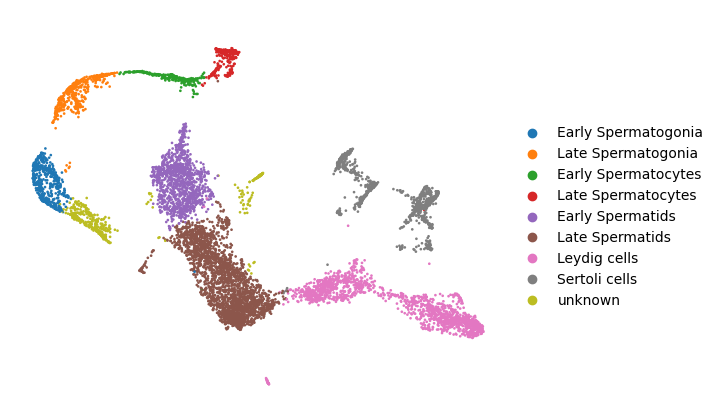

In [146]:
# Visualize UMAP to inspect clusters before annotation
sc.pl.umap(pyEDs_processed, color="leiden_res", legend_loc="on data")

# To manually annotate clusters, you can create a mapping from leiden cluster IDs to custom cell type labels:
# Example:
cluster_annotation = {
    "11": "Early Spermatogonia",
    "2": "Late Spermatogonia",
    "12": "Early Spermatocytes",
    "13": "Late Spermatocytes",
    "0": "Early Spermatids",
    "8": "Late Spermatids",
    "6": "Late Spermatids",
    "3": "Leydig cells",
    "4": "Leydig cells",
    "7": "Sertoli cells",
    "9": "Sertoli cells",
    "10": "Sertoli cells",
    "15": "Sertoli cells",
    "1": "unknown",
    "5": "unknown",
    "14": "Late Spermatids",
    "16": "Leydig cells",
}

# Then, add these labels as a new column in the AnnData object:
pyEDs_processed.obs["Annotated clusters"] = pyEDs_processed.obs["leiden_res"].map(cluster_annotation)

# Visualize annotated clusters:
# Specify the order of legend items by providing a categorical dtype with desired order
import pandas as pd

desired_order = [
    "Early Spermatogonia",
    "Late Spermatogonia",
    "Early Spermatocytes",
    "Late Spermatocytes",
    "Early Spermatids",
    "Late Spermatids",
    "Leydig cells",
    "Sertoli cells",
    "unknown"
]
pyEDs_processed.obs["Annotated clusters"] = pd.Categorical(
    pyEDs_processed.obs["Annotated clusters"],
    categories=desired_order,
    ordered=True
)
sc.pl.umap(
    pyEDs_processed,
    color="Annotated clusters",
    frameon=False,
    legend_loc="right margin",
    title=" ",
    save= "annotated_cluster_leiden.pdf",
    cmap = None
)

In [96]:
support_cell_clusters = ["3", "4", "7", "9", "10", "15", "1"]
pyEDs_processed_ws = pyEDs_processed[~pyEDs_processed.obs["leiden_res"].isin(support_cell_clusters)]
print("LENGHT: " ,pyEDs_processed_ws.obs["leiden_res"].unique())

LENGHT:  ['0', '2', '5', '6', '8', '11', '12', '13', '14', '16']
Categories (10, object): ['0', '2', '5', '6', ..., '12', '13', '14', '16']


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_paga.py:138: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[groups + "_sizes"] = np.array(paga.ns)


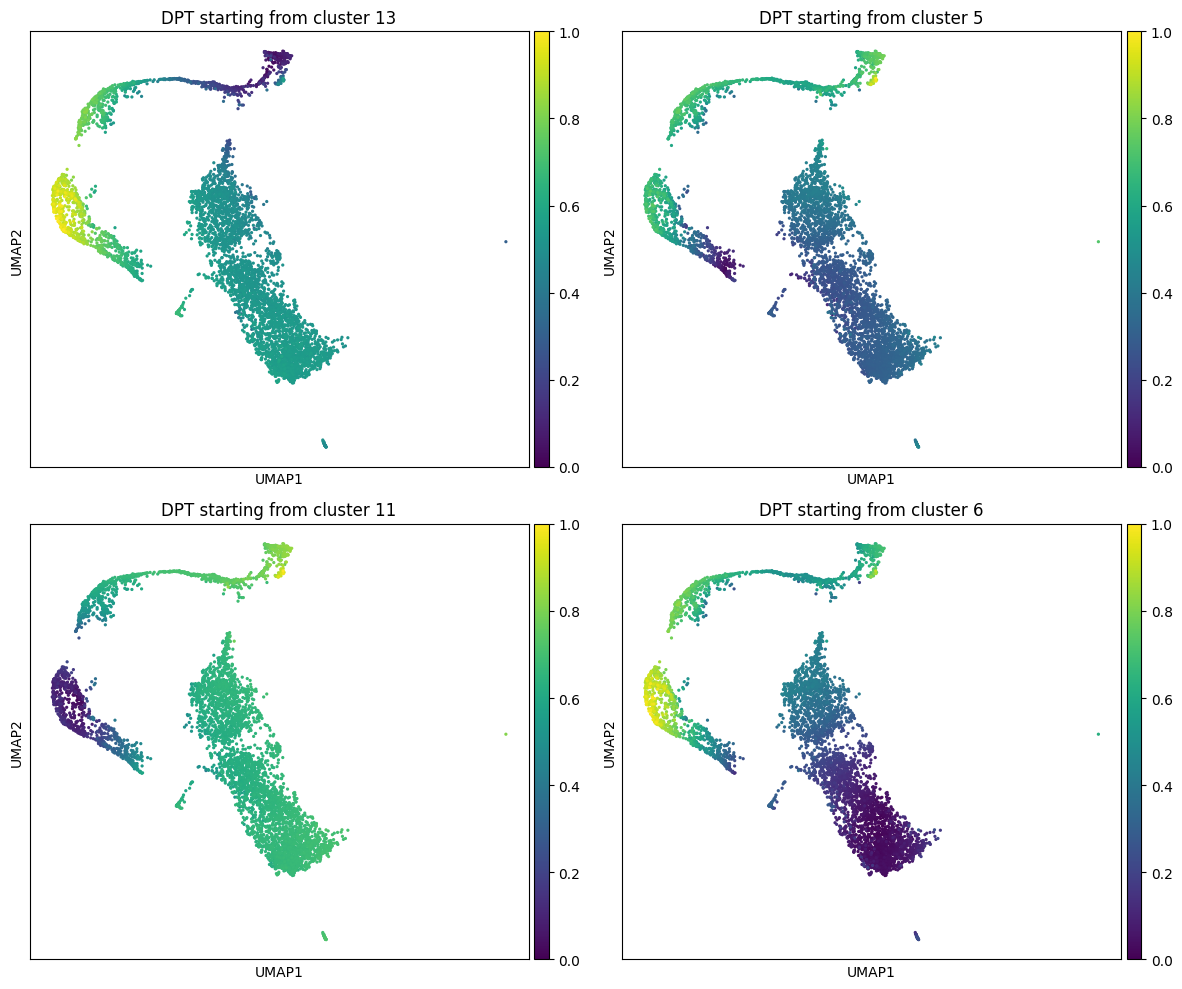

In [ ]:

sc.tl.paga(pyEDs_processed_ws, groups="leiden_res")

# Create a 2x2 figure for DPT plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# DPT with cluster 13 as start
pyEDs_processed_ws.uns['iroot'] = np.flatnonzero(pyEDs_processed_ws.obs['leiden_res'] == '13')[0]
sc.tl.dpt(pyEDs_processed_ws)
sc.pl.umap(pyEDs_processed_ws, color="dpt_pseudotime", title="DPT starting from cluster 13", ax=axes[0, 0], show=False)

# DPT with cluster 5 as start
pyEDs_processed_ws.uns['iroot'] = np.flatnonzero(pyEDs_processed_ws.obs['leiden_res'] == '5')[0]
sc.tl.dpt(pyEDs_processed_ws)
sc.pl.umap(pyEDs_processed_ws, color="dpt_pseudotime", title="DPT starting from cluster 5", ax=axes[0, 1], show=False)

# DPT with cluster 11 as start
pyEDs_processed_ws.uns['iroot'] = np.flatnonzero(pyEDs_processed_ws.obs['leiden_res'] == '11')[0]
sc.tl.dpt(pyEDs_processed_ws)
sc.pl.umap(pyEDs_processed_ws, color="dpt_pseudotime", title="DPT starting from cluster 11", ax=axes[1, 0], show=False)

# DPT with cluster 2 as start
pyEDs_processed_ws.uns['iroot'] = np.flatnonzero(pyEDs_processed_ws.obs['leiden_res'] == '6')[0]
sc.tl.dpt(pyEDs_processed_ws)
sc.pl.umap(pyEDs_processed_ws, color="dpt_pseudotime", title="DPT starting from cluster 6", ax=axes[1, 1], show=False)

plt.tight_layout()
plt.show()

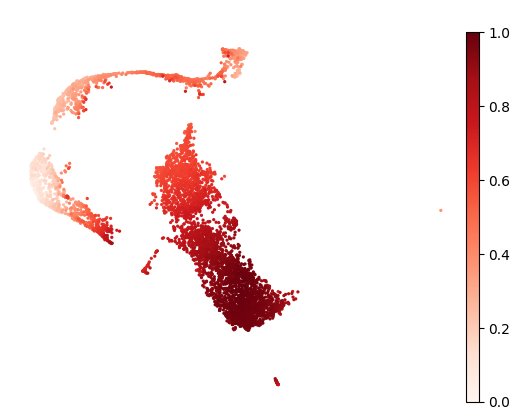

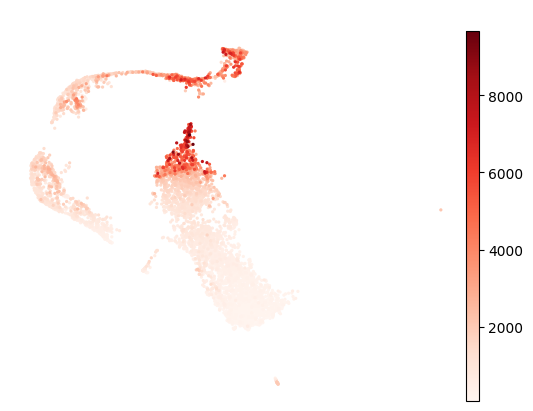

<Figure size 640x480 with 0 Axes>

In [148]:
#change current working directory to 09_soupvsnosoup
os.chdir("/Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/Charité/05_sorted/18_soupX_try/09_soupvsnosoup")

pyEDs_processed_ws.obs['dpt_pseudotime_rev'] = pyEDs_processed_ws.obs['dpt_pseudotime'].max() - pyEDs_processed_ws.obs['dpt_pseudotime']

pyEDs_processed_ws.uns['iroot'] = np.flatnonzero(pyEDs_processed_ws.obs['leiden_res'] == '6')[0]
sc.tl.dpt(pyEDs_processed_ws)
sc.pl.umap(pyEDs_processed_ws, color="dpt_pseudotime_rev",
frameon=False,
cmap = "Reds",
title = " ",
save = "DPT_starting_from_cluster_6.pdf")

sc.pl.umap(pyEDs_processed_ws, color="total_gene_counts",
frameon=False,
cmap = "Reds",
title= " ",
save = "total_gene_counts.pdf")

plt.tight_layout()
plt.show()

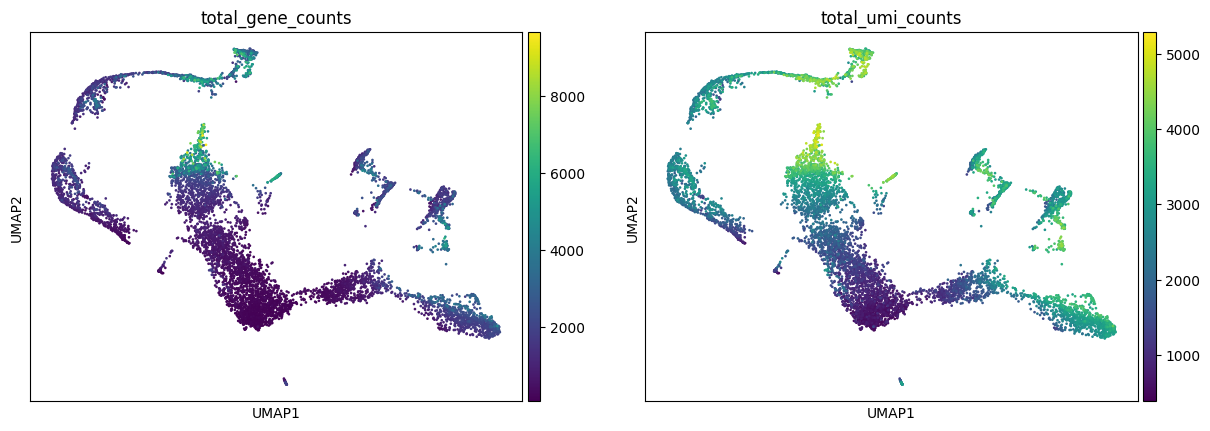


=== Top 10 genes by total gene count for each cluster (side by side) ===

            gene_6  gene_count_6  umi_count_6             gene_8  gene_count_8  umi_count_8             gene_0  gene_count_0  umi_count_0            gene_13  gene_count_13  umi_count_13            gene_12  gene_count_12  umi_count_12
              PRM1           956  4642.943046               PRM1          1040  5295.504560 ENSSSCG00000028485          1162  3562.398186               EEA1            324   1018.119511 ENSSSCG00000021473            263    854.445066
              TNP1           798  3237.219100              RPLP0          1003  3500.500566              RPLP0          1156  4141.132847              AUTS2            321   1164.896878               BOLL            262    708.456726
             RPLP1           660  2555.566120               TNP1           938  3935.460824              GSTM3          1153  3913.577030              STAG1            318    877.268240              FSIP2            262    

In [117]:
# create total gene and total umi counts in pyEDs_processed.obs
pyEDs_processed.obs['total_gene_counts'] = (pyEDs_processed.X > 0).sum(axis=1)
pyEDs_processed.obs["total_umi_counts"] = pyEDs_processed.X.sum(axis=1)

# Plot total gene count and total umi count in pyEDs_processed
sc.pl.umap(pyEDs_processed, color=["total_gene_counts", "total_umi_counts"])

# Combine top 10 genes by total gene count and total UMI count across clusters into merged tables

clusters_of_interest = ["6", "8", "0", "13", "12"]

# Prepare containers for merged tables
gene_count_top = {}
umi_count_top = {}

for clust in clusters_of_interest:
    mask = pyEDs_processed.obs["leiden_res"] == clust
    if np.sum(mask) == 0:
        print(f"Cluster {clust} not found in obs['leiden_res'].\n")
        # fill columns with NaN for this cluster
        gene_count_top[clust] = pd.DataFrame({
            f"gene_{clust}": [np.nan]*10,
            f"gene_count_{clust}": [np.nan]*10,
            f"umi_count_{clust}": [np.nan]*10
        })
        umi_count_top[clust] = pd.DataFrame({
            f"gene_{clust}": [np.nan]*10,
            f"gene_count_{clust}": [np.nan]*10,
            f"umi_count_{clust}": [np.nan]*10
        })
        continue

    expr = pyEDs_processed[mask]
    # Calculate totals for each gene in the cluster (to dense if needed)
    if hasattr(expr.X, "toarray"):
        expr_X = expr.X.toarray()
    else:
        expr_X = expr.X

    gene_counts = (expr_X > 0).sum(axis=0).A1 if hasattr((expr_X > 0).sum(axis=0), "A1") else (expr_X > 0).sum(axis=0)
    umi_counts = expr_X.sum(axis=0).A1 if hasattr(expr_X.sum(axis=0), "A1") else expr_X.sum(axis=0)
    gene_names = np.array(expr.var_names)

    # Top 10 by gene count and UMI count for this cluster
    top_gene_idx = np.argsort(-gene_counts)[:10]
    top_umi_idx = np.argsort(-umi_counts)[:10]

    gene_count_top[clust] = pd.DataFrame({
        f"gene_{clust}": gene_names[top_gene_idx],
        f"gene_count_{clust}": gene_counts[top_gene_idx],
        f"umi_count_{clust}": umi_counts[top_gene_idx]
    }).reset_index(drop=True)

    umi_count_top[clust] = pd.DataFrame({
        f"gene_{clust}": gene_names[top_umi_idx],
        f"gene_count_{clust}": gene_counts[top_umi_idx],
        f"umi_count_{clust}": umi_counts[top_umi_idx]
    }).reset_index(drop=True)

# Merge all cluster columns together into one table per sort criterion (as side-by-side columns)
gene_count_merged_df = pd.concat(gene_count_top.values(), axis=1)
umi_count_merged_df = pd.concat(umi_count_top.values(), axis=1)

print("\n=== Top 10 genes by total gene count for each cluster (side by side) ===\n")
print(gene_count_merged_df.to_string(index=False))
print("\n" + "-"*70 + "\n")
print("=== Top 10 genes by total UMI count for each cluster (side by side) ===\n")
print(umi_count_merged_df.to_string(index=False))
print("\n" + "="*70 + "\n")


# Plot CellTypes

       'POU5F1', 'HIST1H3A', 'ESX1', 'USP26', 'NXF2', 'STK31', 'NLRP4C',
       'TEX15', 'MOV10L1', 'BCLB6B', 'NGN3', 'TBP', 'UBA1Y', 'USP9Y', 'TEX16',
       'PRAMEL3', 'MAGEA5', 'PRAMEL1', 'UTF1', 'HIST1H4M', 'RBMY', 'TEX13',
       'OTT', 'TEX18'],
      dtype='object')


KeyboardInterrupt: 

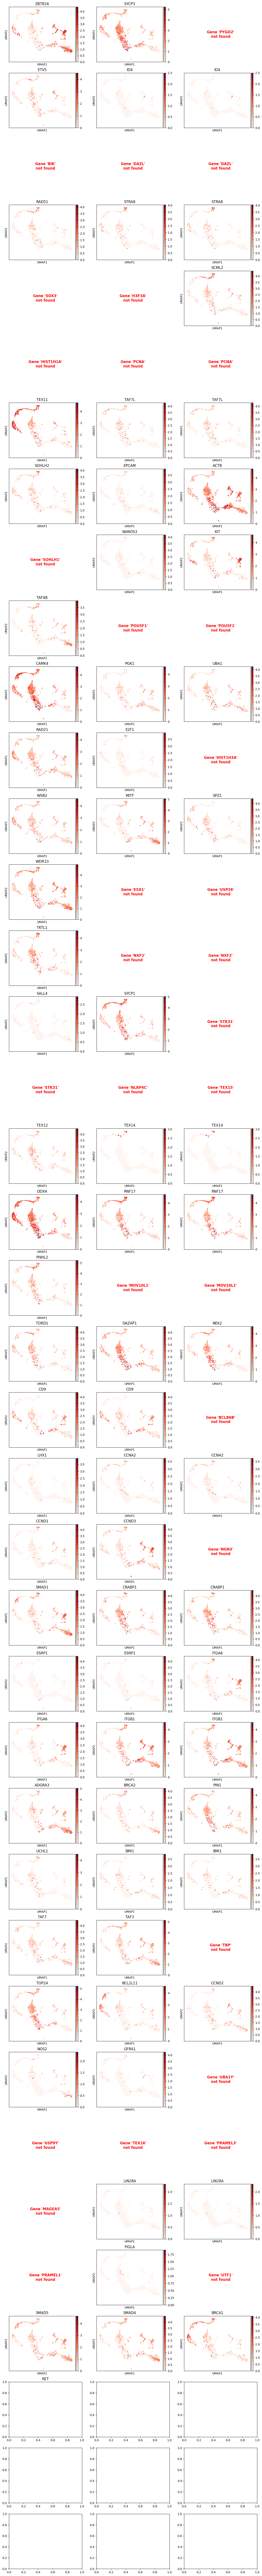

In [58]:
# Create the folder for saving cell type figures if it doesn't already exist
cell_type_figures_dir = "figures/cell_types"
os.makedirs(cell_type_figures_dir, exist_ok=True)

#with open("../02_mapped_gene_markers/exclusive_gene_markers.json", "r") as f:
with open("../02_mapped_gene_markers/all_gene_markers.json", "r") as f:
    marker_genes = json.load(f)

for key, genes in marker_genes.items():
    # skip if no genes for the celltype
    if not genes:
        continue

    # Create a subfolder for this celltype
    this_celltype_dir = os.path.join(cell_type_figures_dir, key.replace(' ', '_'))
    os.makedirs(this_celltype_dir, exist_ok=True)

    # --- Single composite gene score UMAP (as before) ---
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    use_raw = getattr(pyEDs_processed, "raw", None) is not None
    sc.tl.score_genes(pyEDs_processed, gene_list=genes, score_name="{}_score".format(key), use_raw=use_raw)
    sc.pl.umap(
        pyEDs_processed, 
        color="{}_score".format(key), 
        ax=ax, 
        show=False,
        cmap="Reds",
        title=None
    )
    ax.set_title(f"{key}", fontsize=14, fontweight="bold")
    score_out_path = os.path.join(this_celltype_dir, f"0{key.replace(' ', '_')}_score_umap.png")
    plt.savefig(score_out_path, bbox_inches='tight', dpi=150)
    plt.close(fig)

    # --- UMAPs for each individual gene in this celltype ---
    n_genes = len(genes)
    n_cols = 3
    n_rows = (n_genes + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for i, gene in enumerate(genes):
        if gene in pyEDs_processed.var_names:
            sc.pl.umap(
                pyEDs_processed,
                color=gene,
                ax=axes[i],
                show=False,
                cmap="Reds",
                title=gene,
            )
            # Also save an individual plot for this gene in the celltype subfolder
            fig_single, ax_single = plt.subplots(1, 1, figsize=(6, 5))
            sc.pl.umap(
                pyEDs_processed,
                color=gene,
                ax=ax_single,
                show=False,
                cmap="Reds",
                title=gene,
            )
            ax_single.set_title(gene, fontsize=14, fontweight="bold")
            single_gene_out_path = os.path.join(this_celltype_dir, f"{gene}_umap.png")
            plt.savefig(single_gene_out_path, bbox_inches='tight', dpi=150)
            plt.close(fig_single)
        else:
            axes[i].set_axis_off()
            axes[i].text(
                0.5, 0.5,
                f"Gene '{gene}'\nnot found",
                color="red",
                ha="center",
                va="center",
                fontsize=12,
                fontweight="bold"
            )

    for j in range(n_genes, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"UMAPs for genes in {key}", fontsize=14, fontweight="bold")
    multi_umap_out_path = os.path.join(this_celltype_dir, f"0{key.replace(' ', '_')}_genes_umaps.png")
    plt.savefig(multi_umap_out_path, bbox_inches='tight', dpi=150)
    plt.close(fig)


# SINGLE gene UMAP

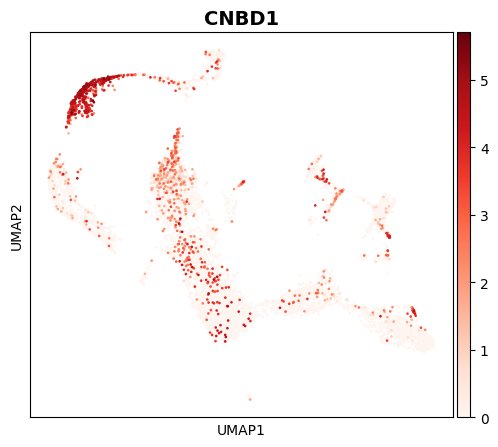

In [102]:
#change current working directory to 09_soupvsnosoup
os.chdir("/Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/Charité/05_sorted/18_soupX_try/09_soupvsnosoup")

gene = "CNBD1"
fig_single, ax_single = plt.subplots(1, 1, figsize=(6, 5))
sc.pl.umap(
    pyEDs_processed,
    color=gene,
    ax=ax_single,
    show=False,
    cmap="Reds",
    title=gene,
)
ax_single.set_title(gene, fontsize=14, fontweight="bold")
single_gene_out_path = os.path.join(f"{gene}_umap.png")
plt.savefig(single_gene_out_path, bbox_inches='tight', dpi=150)
plt.show()

# DEA PLOTS
## function

In [104]:
def DifferentialExpressionAnalysisComparison(pyED_processed, pyEDs_processed, marker_genes, cell_types, leiden_res=0.2):
    """
    Run DE analysis for both pyED  and pyEDs  and create comparison plots.
    
    Parameters:
    -----------
    pyED_processed : AnnData
        Preprocessed pyED dataset (no soup correction)
    pyEDs_processed : AnnData
        Preprocessed pyEDs dataset (soup correction applied)
    marker_genes : dict
        Dictionary mapping cell types to marker genes
    cell_types : list
        List of cell types to analyze
    leiden_res : float
        Leiden clustering resolution (default: 0.2)
    """
    # Suppress tqdm warnings
    try:
        import tqdm.auto
    except Exception:
        pass
    try:
        import tqdm.autonotebook
        if hasattr(tqdm.autonotebook, 'tqdm'):
            tqdm.autonotebook.tqdm = tqdm.auto.tqdm
    except Exception:
        pass

    res_print = str(leiden_res).replace('.', '_')
    print("RUNNING DIFFERENTIAL EXPRESSION ANALYSIS WITH RESOLUTION: ".upper(), leiden_res)
    print("CREATING PLOTS FOR ALL THESE CELL TYPES:\n", cell_types)

    # Change to notebook's directory (09_soupvsnosoup) to save figures there
    notebook_dir = "/Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/Charité/05_sorted/18_soupX_try/09_soupvsnosoup"
    os.chdir(notebook_dir)
    
    # Use preprocessed datasets
    datasets = [pyED_processed, pyEDs_processed]
    dataset_names = ["pyED", "pyEDs"]
    dataset_save_names = ["pyED_nosoup", "pyEDs_soup"]
    
    # Create figures directory if it doesn't exist
    os.makedirs("figures", exist_ok=True)
    
    # Plot counter
    plot_counter = 1
    
    # 1. PCA Variance Ratio - Side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    for ax, data, title in zip(axes, datasets, dataset_names):
        var_exp = data.uns['pca']['variance_ratio'][:50]
        ax.bar(range(1, 51), var_exp)
        ax.set_xlabel("Principal Component")
        ax.set_ylabel("Explained Variance Ratio (log)")
        ax.set_yscale("log")
    plt.tight_layout()
    plt.savefig(f"figures/{plot_counter:02d}_PCA_variance_ratio_comparison.png", dpi=300, bbox_inches="tight")
    plot_counter += 1
    
    
    # 2. Simple UMAP - Side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    for idx, (ax, data, title, save_name) in enumerate(zip(axes, datasets, dataset_names, dataset_save_names)):
        sc.pl.umap(data, ax=ax, show=False, frameon=False)
    plt.tight_layout()
    plt.savefig(f"figures/{plot_counter:02d}_UMAP_simple_comparison.png", dpi=300, bbox_inches="tight")
    plot_counter += 3  # +1 for comparison, +2 for individual plots
    
    
    # 3. UMAP with marker genes - Side by side for each cell type
    # Create subfolder for marker gene plots
    marker_genes_dir = "figures/UMAP_marker_genes"
    os.makedirs(marker_genes_dir, exist_ok=True)
    marker_plot_counter = 1  # Separate counter for marker gene plots
    
    marker_genes_in_data = {}
    for ct, markers in marker_genes.items():
        markers_found = []
        for marker in markers:
            if marker in datasets[0].var.index:
                markers_found.append(marker)
        marker_genes_in_data[ct] = markers_found
    
    # for ct in cell_types:
    #     genes_to_plot = marker_genes_in_data.get(ct, [])
    #     if not genes_to_plot:
    #         print(f"  [SKIP] No marker genes found for {ct}; skipping UMAP plot.")
    #         continue
        
    #     # Plot each gene separately for side-by-side comparison
    #     for gene in genes_to_plot:
    #         fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    #         ct_safe = ct.replace(" ", "_")
    #         gene_safe = gene.replace("/", "_").replace(" ", "_")
    #         for ax, data, title in zip(axes, datasets, dataset_names):
    #             sc.pl.umap(
    #                 data,
    #                 color=gene,
    #                 vmin=0,
    #                 vmax=3,
    #                 sort_order=False,
    #                 frameon=False,
    #                 cmap="Reds",
    #                 ax=ax,
    #                 show=False,
    #             )
    #         plt.tight_layout()
    #         plt.savefig(f"{marker_genes_dir}/{marker_plot_counter:02d}_UMAP_{ct_safe}_{gene_safe}_comparison.png", dpi=300, bbox_inches="tight")
    #         marker_plot_counter += 1
            
    
    # 4. UMAP with Leiden clusters - One figure per dataset, distinguishing both conditions side-by-side

    # We assume datasets always contains [original, soupx]
    for idx, (data, title, save_name) in enumerate(zip(datasets, dataset_names, dataset_save_names)):
        # Only do this once for idx 0 and once for idx 1 (i.e., two figures total)
        fig, ax = plt.subplots(figsize=(7, 6))
        sc.pl.umap(
            data,
            color="leiden_res",
            ax=ax,
            legend_loc="on data",
            legend_fontsize=16,        # Increase size
            legend_fontweight="bold",  # Make bold (if supported)
            show=False,
            frameon=False,
            title=" "
        )
        # Assign a descriptive filename: _soupx only for second dataset
        suffix = "_soupx" if idx == 1 else ""
        plt.tight_layout()
        plt.savefig(f"figures/{plot_counter:02d}_UMAP_leiden_{save_name}{suffix}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)
        plot_counter += 1
    
    
    # 5. Dotplots - Beneath each other
    found_markers = {
        ct: [m for m in ct_markers if m in datasets[0].var.index]
        for ct, ct_markers in marker_genes.items()
        if ct in cell_types
    }
    
    # # Exclusive dotplot
    # for data, name, save_name in zip(datasets, dataset_names, dataset_save_names):
    #     sc.pl.dotplot(
    #         data,
    #         groupby="leiden_res",
    #         var_names=found_markers,
    #         standard_scale="var",
    #         cmap="Reds",
    #         show=False,
    #     )
    #     plt.savefig(f"figures/{plot_counter:02d}_dotplot_exclusive_{save_name}.png", dpi=300, bbox_inches="tight")
    #     plot_counter += 1
    
    # Run Wilcoxon test for both datasets
    for data in datasets:
        sc.tl.rank_genes_groups(
            data, groupby="leiden_res", method="wilcoxon", key_added="dea_leiden_res"
        )
    
    # # Wilcoxon dotplot with exclusive markers
    # for data, name, save_name in zip(datasets, dataset_names, dataset_save_names):
    #     sc.pl.rank_genes_groups_dotplot(
    #         data, groupby="leiden_res", standard_scale="var", key="dea_leiden_res",
    #         cmap="Reds", var_names=found_markers, show=False,
    #     )
    #     plt.savefig(f"figures/{plot_counter:02d}_dotplot_wilcoxon_exclusive_{save_name}.png", dpi=300, bbox_inches="tight")
    #     plot_counter += 1
    
    # Wilcoxon dotplot top 3
    for data, name, save_name in zip(datasets, dataset_names, dataset_save_names):
        sc.pl.rank_genes_groups_dotplot(
            data, groupby="leiden_res", standard_scale="var", n_genes=3, key="dea_leiden_res",
            cmap="Reds", show=False
        )
        plt.savefig(f"figures/{plot_counter:02d}_dotplot_wilcoxon_top3_{save_name}.png", dpi=300, bbox_inches="tight")
        plot_counter += 1
    
    # Wilcoxon dotplot top 5 specific clusters
    for data, name, save_name in zip(datasets, dataset_names, dataset_save_names):
        sc.pl.rank_genes_groups_dotplot(
            data, groupby="leiden_res", standard_scale="var", n_genes=3, key="dea_leiden_res",
            cmap="Reds", show=False, groups=["5", "14", "0", "8", "6", "1", "16"]
        )
        plt.savefig(f"figures/{plot_counter:02d}_specificgenes_dotplot_wilcoxon_top5_{save_name}.png", dpi=300, bbox_inches="tight")
        plot_counter += 1

    # # Wilcoxon heatmap - Beneath each other
    # for data, name, save_name in zip(datasets, dataset_names, dataset_save_names):
    #     sc.pl.rank_genes_groups_heatmap(
    #         data, groupby="leiden_res", key="dea_leiden_res", 
    #         cmap="Reds", show=False
    #     )
    #     plt.savefig(f"figures/{plot_counter:02d}_heatmap_wilcoxon_{save_name}.png", dpi=300, bbox_inches="tight")
    #     plot_counter += 1
    
    # 6. Violin plots - Only plot for the second dataset
    # Marker genes violins
    all_marker_genes = []
    for markers in found_markers.values():
        all_marker_genes.extend(markers)
    seen = set()
    all_marker_genes_unique = [x for x in all_marker_genes if not (x in seen or seen.add(x))]

    # if all_marker_genes_unique and len(datasets) > 1:
    #     # Only plot for the second dataset (index 1)
    #     data = datasets[1]
    #     name = dataset_names[1]
    #     save_name = dataset_save_names[1]
    #     n_cols = 4
    #     n_genes = len(all_marker_genes_unique)
    #     n_rows = (n_genes + n_cols - 1) // n_cols

    #     fig, axes = plt.subplots(
    #         nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4), squeeze=False
    #     )
    #     axes = axes.flatten()

    #     for idx, gene in enumerate(all_marker_genes_unique):
    #         ax = axes[idx]
    #         sc.pl.violin(
    #             data,
    #             keys=gene,
    #             groupby="leiden_res",
    #             ax=ax,
    #             show=False
    #         )
    #         ax.set_ylabel("")
    #         ax.set_title("")
    #         ax.set_xlabel("")
    #         # Add gene name horizontally in upper left corner
    #         ax.text(0.05, 0.95, gene, transform=ax.transAxes, fontsize=14, fontweight='bold',
    #                 horizontalalignment='left', verticalalignment='top')

    #     for idx in range(len(all_marker_genes_unique), len(axes)):
    #         fig.delaxes(axes[idx])

    #     plt.suptitle(f"{name}: Marker genes", fontsize=16, y=1.02)
    #     plt.tight_layout()
    #     plt.savefig(f"figures/{plot_counter:02d}_violin_markers_{save_name}.png", dpi=300, bbox_inches="tight")
    #     plot_counter += 1


    # Top 5 DEA gene violins - plot all top 5 for every cluster as individual violins

    # # Only plot for pyEDs_processed (assuming index 1)
    # data = datasets[1]
    # name = dataset_names[1]
    # save_name = dataset_save_names[1]

    # # Make directory for outputs
    # outdir = "figures/wilcoxon_cluster_top5_DEG"
    # os.makedirs(outdir, exist_ok=True)

    # top_n = 5
    # group_names = data.uns["dea_leiden_res"]["names"].dtype.names

    # for group in group_names:
    #     # Get top 5 genes for this cluster
    #     genes = data.uns["dea_leiden_res"]["names"][group][:top_n]
    #     genes = [g for g in genes if g is not None and g != ""]
    #     n_genes = len(genes)
    #     if n_genes == 0:
    #         continue
    #     n_cols = 3
    #     n_rows = (n_genes + n_cols - 1) // n_cols

    #     fig, axes = plt.subplots(
    #         nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4), squeeze=False
    #     )
    #     axes = axes.flatten()

    #     for idx, gene in enumerate(genes):
    #         ax = axes[idx]
    #         sc.pl.violin(
    #             data,
    #             keys=gene,
    #             groupby="leiden_res",
    #             ax=ax,
    #             show=False
    #         )
    #         ax.set_ylabel("")
    #         ax.set_title("")
    #         ax.set_xlabel("")
    #         # Add gene name horizontally in upper left corner
    #         ax.text(0.05, 0.95, gene, transform=ax.transAxes, fontsize=14, fontweight='bold',
    #                 horizontalalignment='left', verticalalignment='top')

    #     # Remove unused axes if there are fewer genes than axes
    #     for idx in range(n_genes, len(axes)):
    #         fig.delaxes(axes[idx])

    #     plt.suptitle(f"Cluster {group} Top 5 DEA genes (Wilcoxon)", fontsize=16, y=1.02)
    #     plt.tight_layout()
    #     plt.savefig(f"{outdir}/cluster_{group}_top5_DEG.png", dpi=300, bbox_inches="tight")
    #     plt.close(fig)

      
    return datasets[0], datasets[1]

## run

RUNNING DIFFERENTIAL EXPRESSION ANALYSIS WITH RESOLUTION:  0.9
CREATING PLOTS FOR ALL THESE CELL TYPES:
 ['Early Sgonia', 'Late Sgonia', 'Early Scytes', 'Late Scytes', 'Round Stids', 'Later Stids', 'Sertoli', 'Leydig']
categories: 0, 1, 2, etc.
var_group_labels: 5, 14, 0, etc.
categories: 0, 1, 2, etc.
var_group_labels: 5, 14, 0, etc.


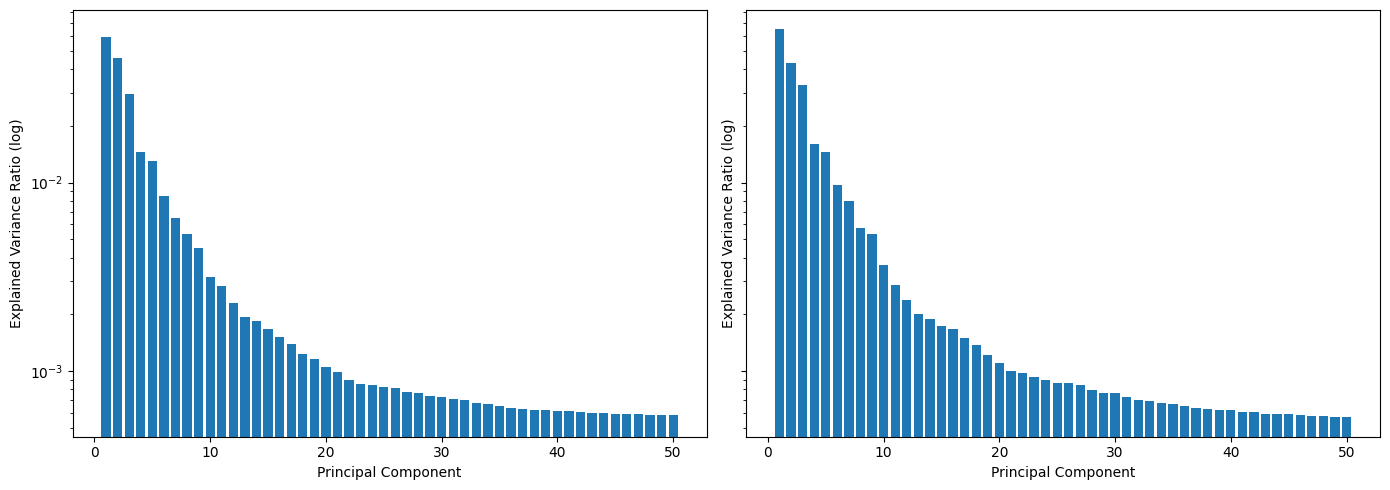

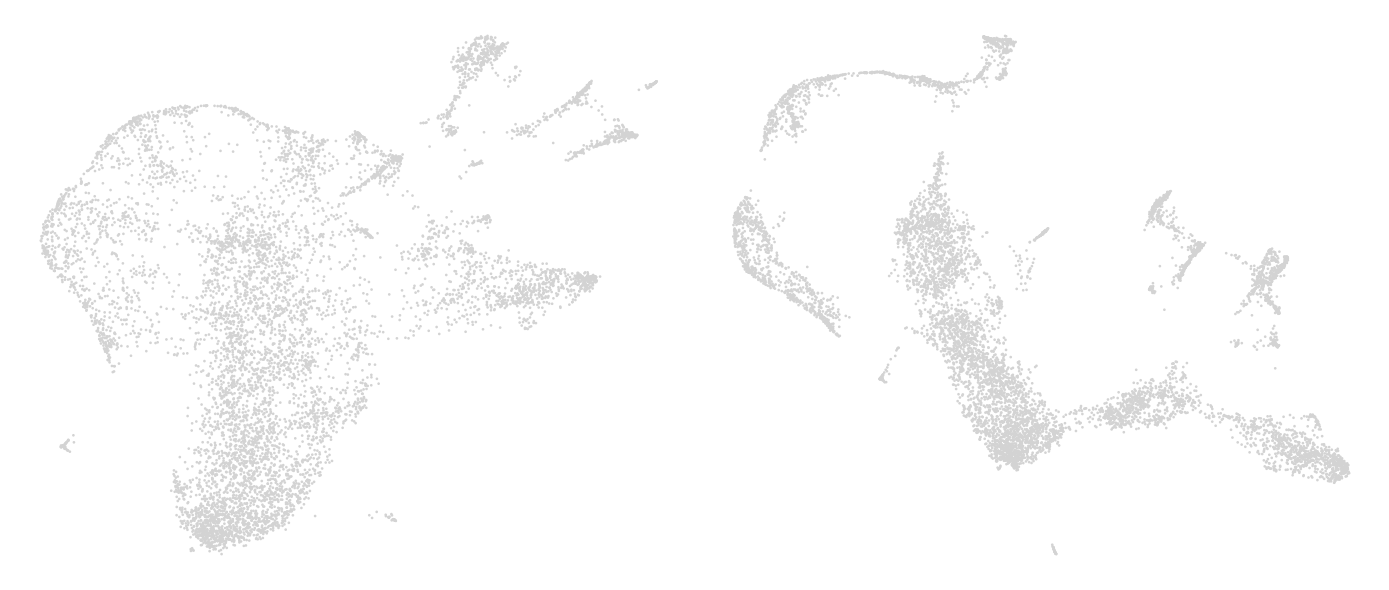

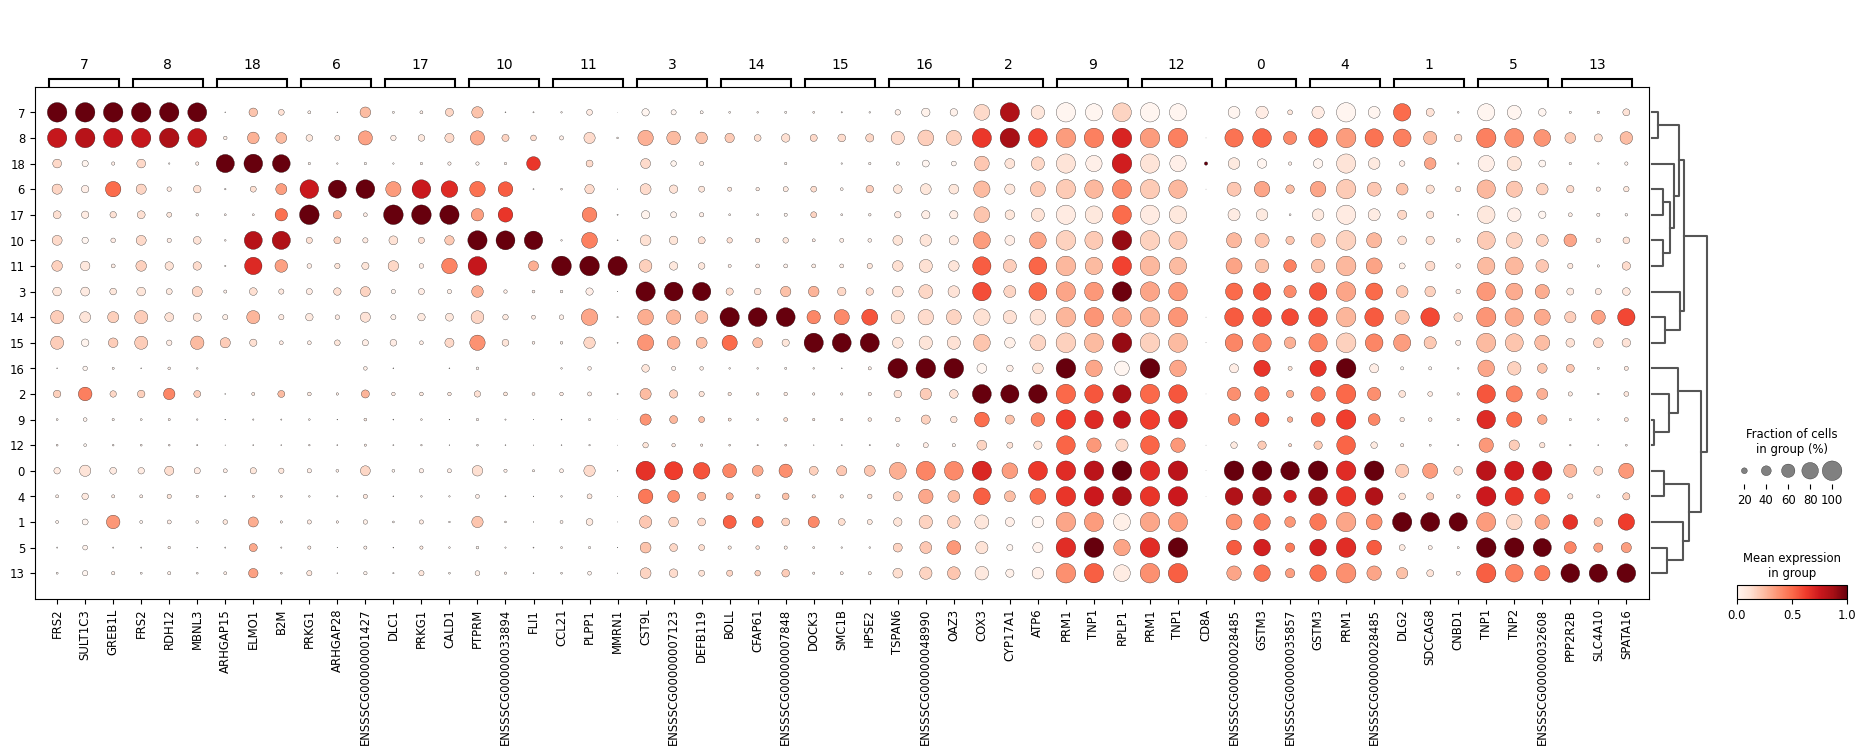

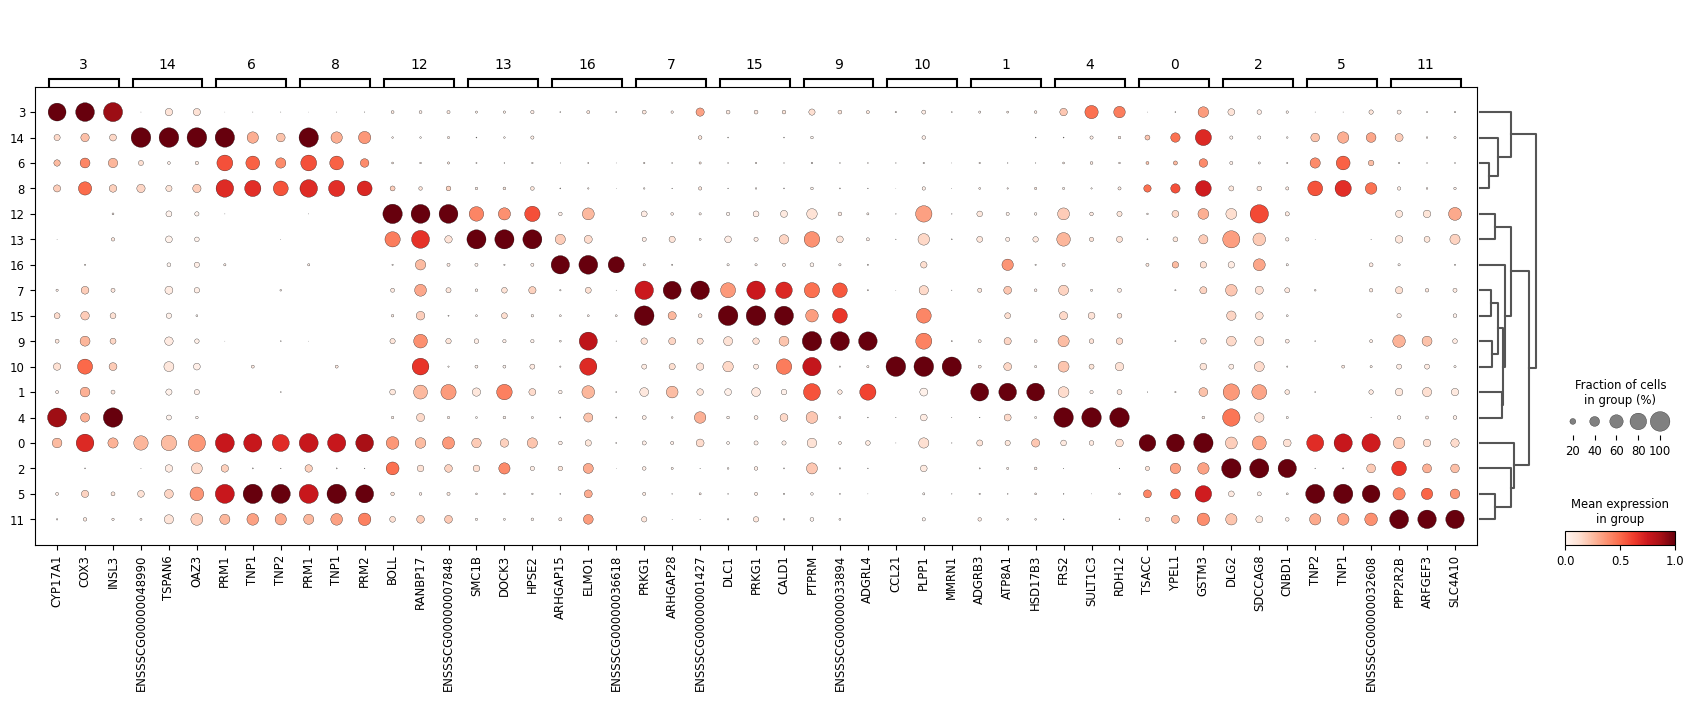

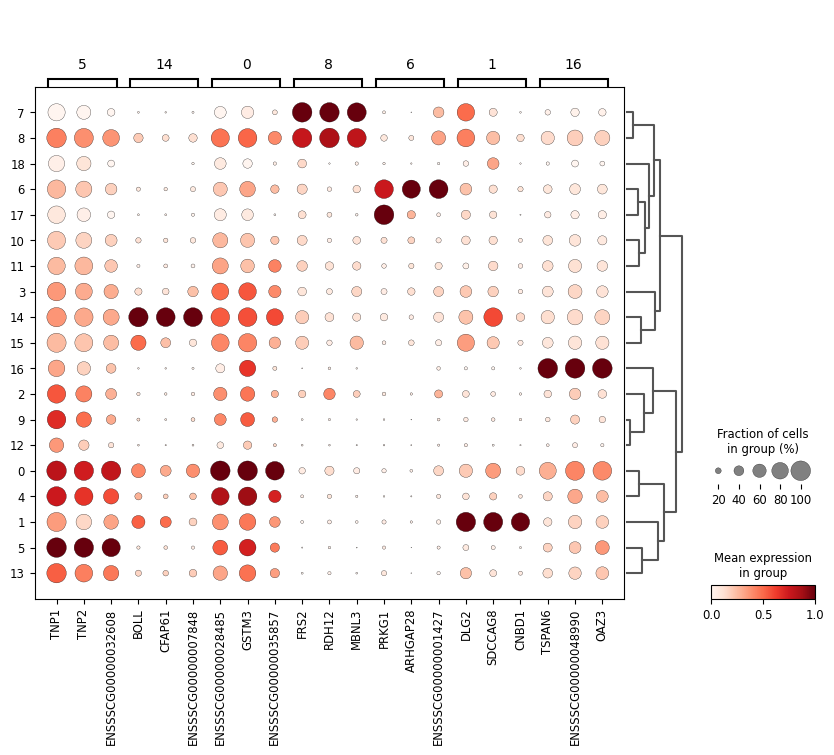

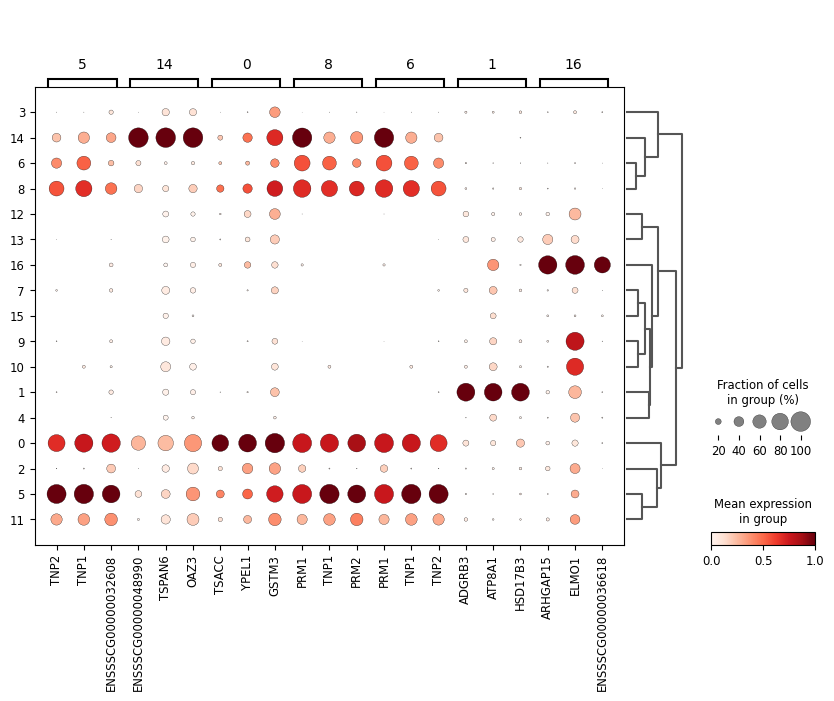

In [105]:

# Run comprehensive DE analysis comparison
pyED_final, pyEDs_final = DifferentialExpressionAnalysisComparison(
    pyED_processed, pyEDs_processed, marker_genes, json_marker_cell_types, custom_leiden_res
)

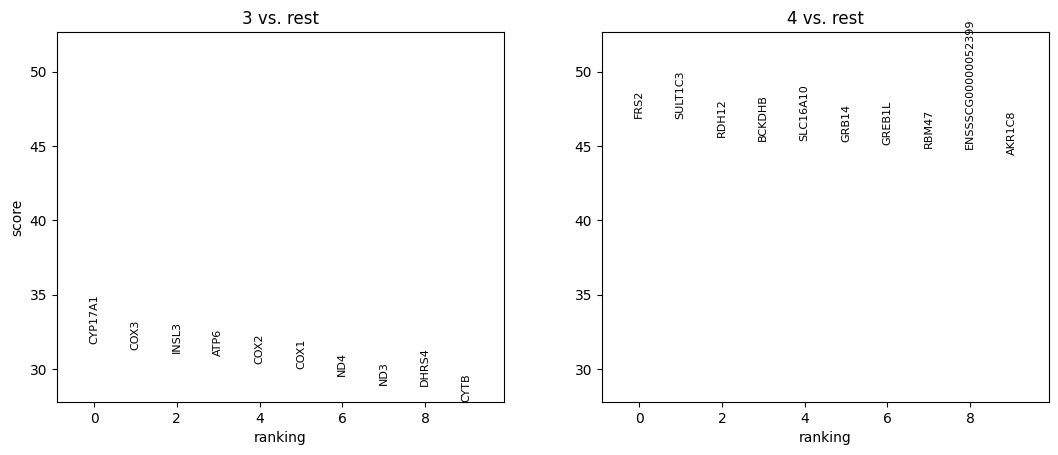

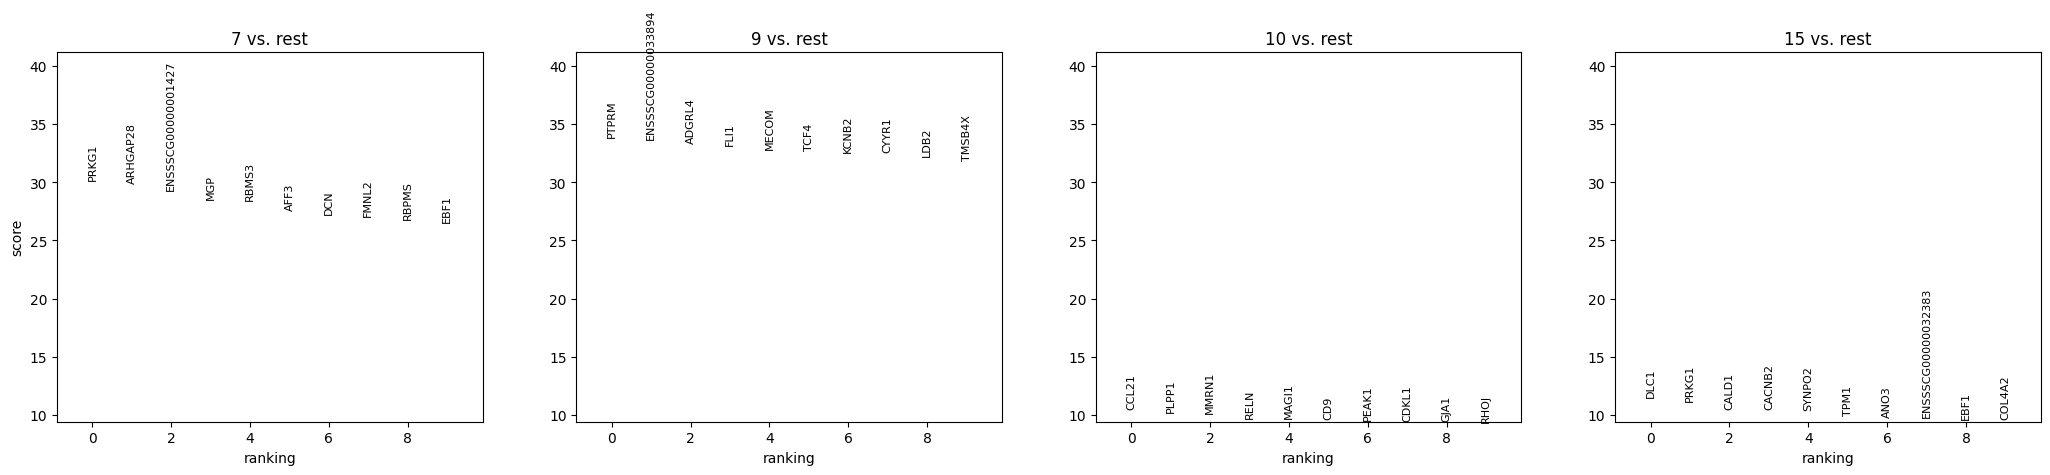

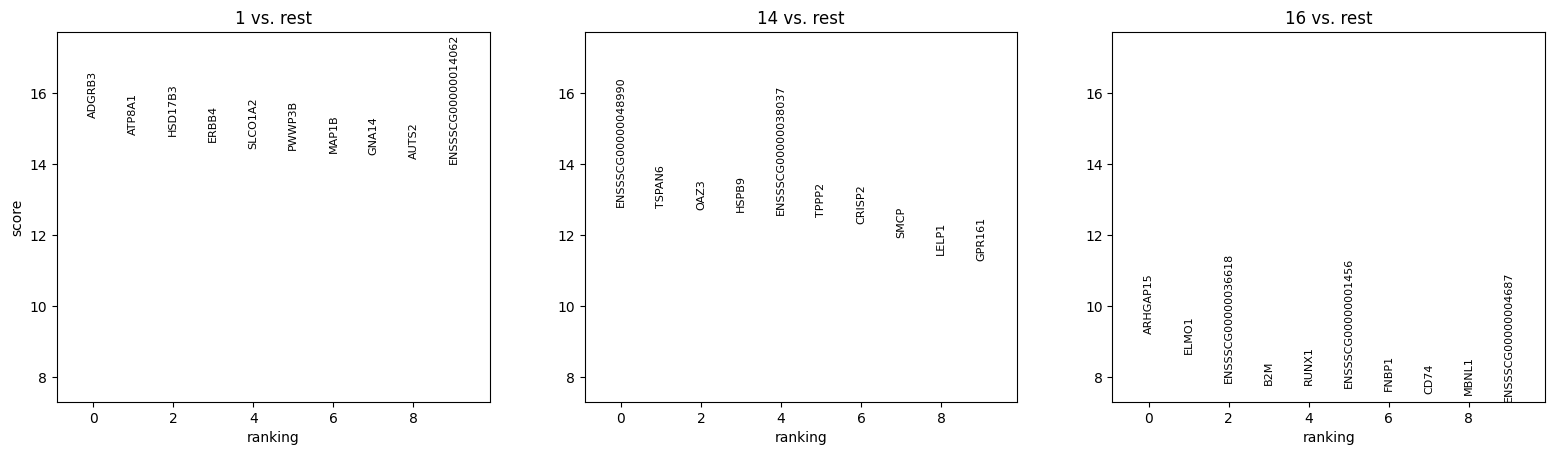

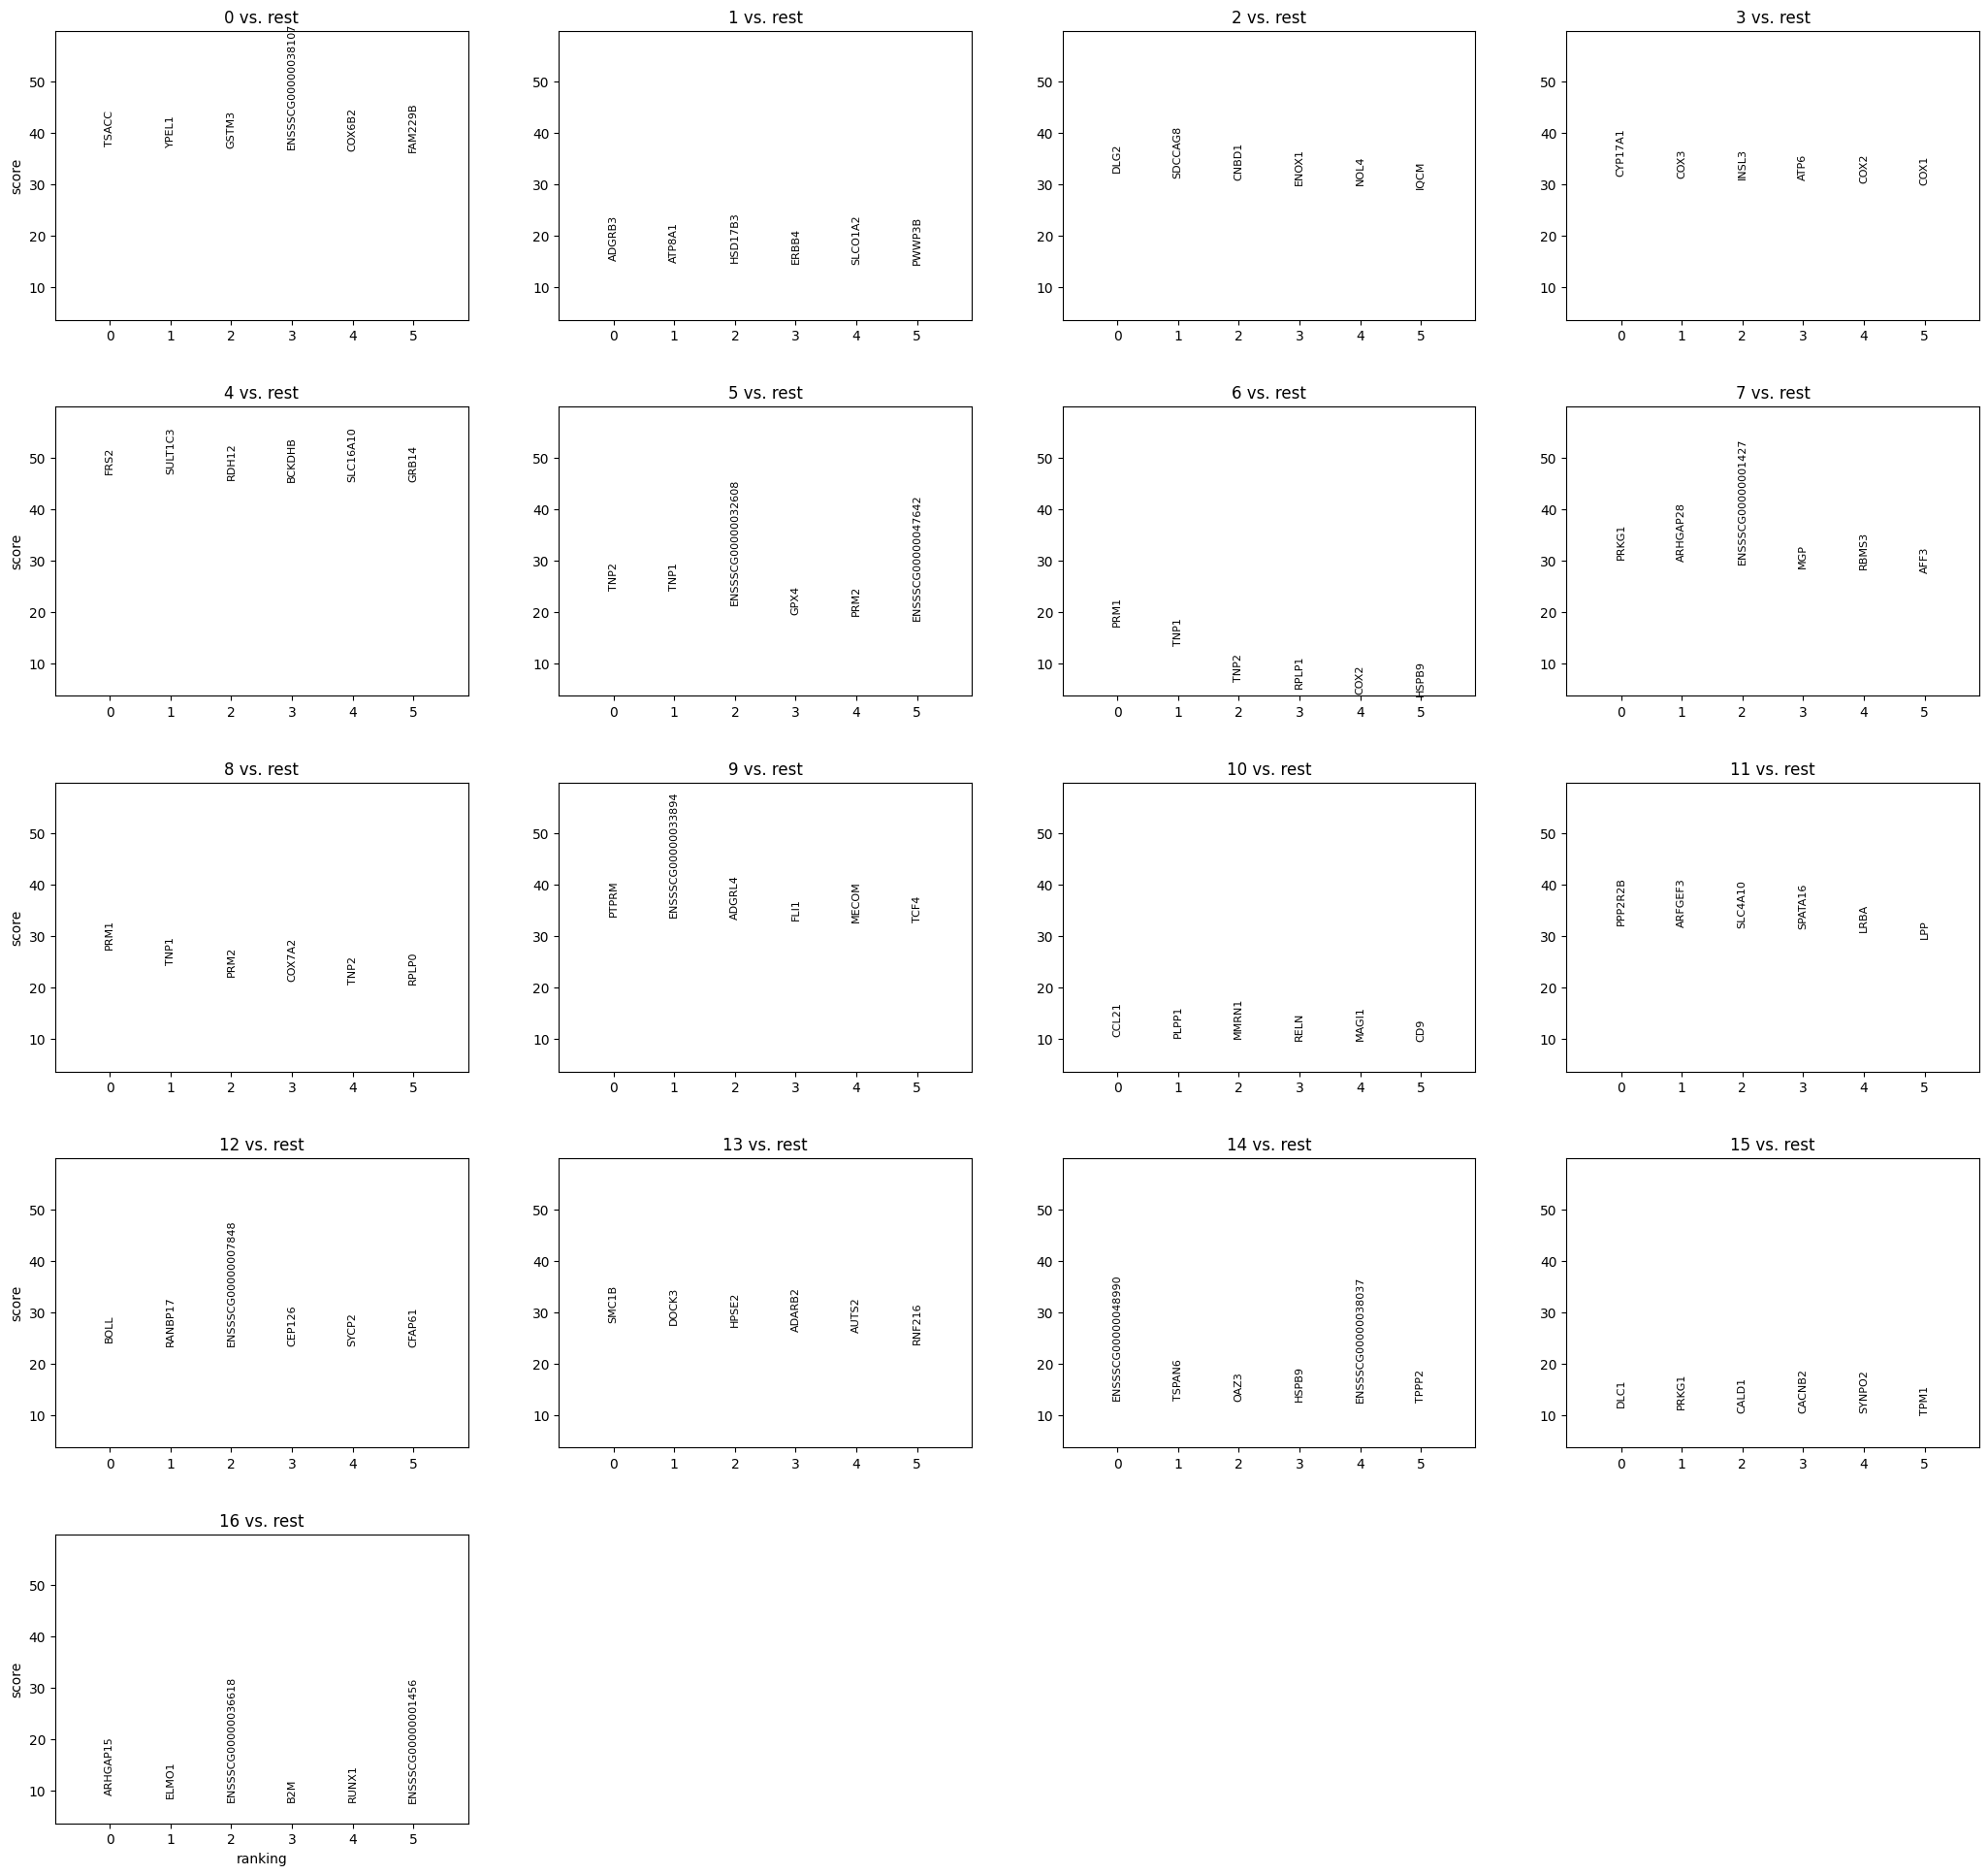

In [112]:
sc.pl.rank_genes_groups(pyEDs_processed, groupby="leiden_res", groups=["3", "4",], standard_scale="var", n_genes=10, key="dea_leiden_res", save="cluster_3_4_top5_DEG.png")
sc.pl.rank_genes_groups(pyEDs_processed, groupby="leiden_res", groups=["7", "9", "10", "15"], standard_scale="var", n_genes=10, key="dea_leiden_res", save="cluster_7_9_10_15_top5_DEG.png")
sc.pl.rank_genes_groups(pyEDs_processed, groupby="leiden_res", groups=["1", "14", "16"], standard_scale="var", n_genes=10, key="dea_leiden_res", save="cluster_1_14_16_top5_DEG.png")

sc.pl.rank_genes_groups(pyEDs_processed, groupby="leiden_res", standard_scale="var", n_genes=6, key="dea_leiden_res", save="all_top6_DEG.png")

# SINGLE violin plot

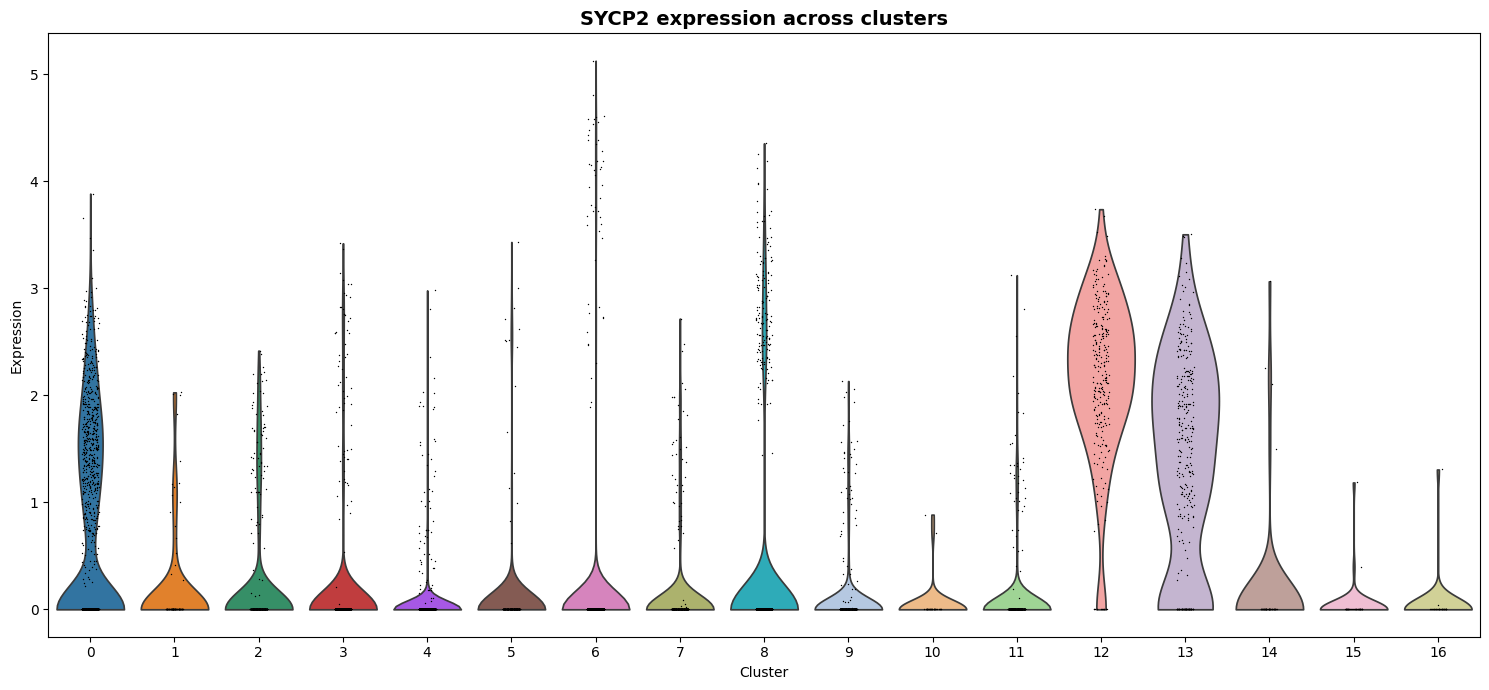

In [ ]:
# Specify the gene you want to plot
gene_to_plot = "SMCP" # ZNRF4 , CRISP2
import os

# Generate the folder 'single_violin/' if it does not exist
output_folder = "single_violin"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Dataset to use (pyEDs_processed was index 1 in previous code)
data = pyEDs_final  # or pyEDs_processed if you want unfiltered

# Get list of clusters (as string if categorical)
clusters = data.obs["leiden_res"].cat.categories if "leiden_res" in data.obs else sorted(data.obs["leiden_res"].unique())
n_clusters = len(clusters)


    #     n_cols = 3
    #     n_rows = (n_genes + n_cols - 1) // n_cols

    #     fig, axes = plt.subplots(
    #         nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4), squeeze=False
    #     )
fig, ax = plt.subplots(figsize=(15, 7))

sc.pl.violin(
    data,
    keys=gene_to_plot,
    groupby="leiden_res",
    ax=ax,
    show=False,
    stripplot=True
)
ax.set_title(f"{gene_to_plot} expression across clusters", fontsize=14, fontweight='bold')
ax.set_ylabel("Expression")
ax.set_xlabel("Cluster")

# Save plot in the output_folder and name file after the gene
output_path = os.path.join(output_folder, f"{gene_to_plot}_violin.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

# Map Top5 DEG to CellTypes

In [ ]:
pyEDs_final.uns.keys()

dict_keys(['X_name', 'log1p', 'pca', 'neighbors', 'umap', 'leiden_res', 'leiden_res_colors', 'dea_leiden_res', 'dendrogram_leiden_res'])

In [ ]:
LG = "leiden_res"
DEG = "dea_leiden_res"
HEG = "dea_leiden_res_filtered"

# CUSTOMIZE HERE
used_key = DEG
n_top_genes = 100

df = sc.get.rank_genes_groups_df(pyEDs_final, group=None, key=used_key)
top5_genes_list = []
groups = df['group'].unique()
for group in groups:
    group_df = df[df['group'] == group].head(n_top_genes)
    top5_genes_list.append(group_df)
top5_genes_df = pd.concat(top5_genes_list, ignore_index=True)

# print the group 13 and show the top 10
top5_genes_df[top5_genes_df['group'] == 13].head(10)

Empty DataFrame
Columns: [group, names, scores, logfoldchanges, pvals, pvals_adj]
Index: []

In [ ]:
with open("../02_mapped_gene_markers/exclusive_gene_markers.json", "r") as f:
    exclusive_marker_genes = json.load(f)
with open("../02_mapped_gene_markers/all_gene_markers.json", "r") as f:
    all_marker_genes = json.load(f)

In [ ]:
# For each row in top5_genes_df, find which cell types (keys from marker_genes) have this gene symbol in their marker list
def get_matching_cell_types(gene, json_cell_type_markers):
    matching_cell_types = []
    for cell_type, marker_gene_list in json_cell_type_markers.items():
        if gene in marker_gene_list:
            matching_cell_types.append(cell_type)
    if matching_cell_types:
        return matching_cell_types
    else:
        # return Na
        return np.nan


In [ ]:
top5_genes_df['exclusive_cell_types'] = top5_genes_df['names'].apply(lambda gene: get_matching_cell_types(gene, exclusive_marker_genes))
top5_genes_df['all_cell_types'] = top5_genes_df['names'].apply(lambda gene: get_matching_cell_types(gene, all_marker_genes))

## pretty print

In [ ]:
# Print rows where any of the marker gene type columns does not have "N/A"
def not_all_NA(row):
    marker_cols = ['exclusive_cell_types', 'all_cell_types']
    return any((row[col] is not None) and (str(row[col]) != "N/A" and str(row[col]) != "nan") for col in marker_cols)

filtered_top5 = top5_genes_df[top5_genes_df.apply(not_all_NA, axis=1)]


# save to excel
filtered_top5.to_excel("figures/top5_genes_df_filtered.xlsx", index=False)
top5_genes_df.to_excel("figures/top5_genes_df.xlsx", index=False)

In [ ]:
filtered_top5[["group", "names", "scores", "exclusive_cell_types", "all_cell_types"]]

group    names     scores exclusive_cell_types  \
14       0     MEA1  35.289783                  NaN   
15       0     SMCP  35.158974                  NaN   
17       0   CRISP2  35.076263        [Round Stids]   
25       0    SPA17  34.334431                  NaN   
30       0     PRM1  33.941486        [Later Stids]   
46       0     YBX2  33.393085                  NaN   
49       0    MEIG1  33.148163                  NaN   
95       0      GK2  31.273712                  NaN   
98       0     TNP1  31.225885        [Later Stids]   
217      2    STAT4  27.116133                  NaN   
273      2     CHD5  21.189510                  NaN   
300      3  CYP17A1  31.670601             [Leydig]   
464      4  CYP17A1  34.980591             [Leydig]   
500      5     TNP2  24.250315                  NaN   
501      5     TNP1  24.226980        [Later Stids]   
510      5     PRM1  16.765371        [Later Stids]   
551      5    SPA17   9.983306                  NaN   
600      6     PRM1  17.143530        [Later Stids]   
601      6     TNP1  13.501328        [Later Stids]   
602      6     TNP2   6.438016                  NaN   
737      7    PTCH1  22.142962                  NaN   
800      8     PRM1  27.483469        [Later Stids]   
801      8     TNP1  24.434050        [Later Stids]   
804      8     TNP2  20.741129                  NaN   
815      8   CRISP2  14.289255        [Round Stids]   
844      8     MEA1   9.364311                  NaN   
847      8    SPA17   9.284319                  NaN   
887      8     SMCP   6.195680                  NaN   
978      9   ZBTB16  23.835102       [Early Sgonia]   
1005    10      CD9   9.649811                  NaN   
1195    11     CHD5  21.014973                  NaN   
1200    12     BOLL  24.201279                  NaN   
1204    12    SYCP2  23.347017                  NaN   
1240    12   PIWIL1  21.037279                  NaN   
1287    12    RNF17  19.881218                  NaN   
1291    12    ADAD1  19.845562                  NaN   
1300    13    SMC1B  27.931185                  NaN   
1310    13    RNF17  23.114613                  NaN   
1353    13    TKTL1  19.493114                  NaN   
1375    13   PIWIL2  18.841072                  NaN   
1384    13    TEX11  18.441832        [Late Sgonia]   
1406    14   CRISP2  12.331252        [Round Stids]   
1407    14     SMCP  11.939239                  NaN   
1414    14     PRM1  10.713790        [Later Stids]   
1420    14    ZNRF4  10.153022                  NaN   
1476    14   GAPDHS   6.302512                  NaN   
1497    14     PGK2   5.444245                  NaN   
1651    16    CCND3   5.482807                  NaN   

                                         all_cell_types  
14    [Early Scytes, Late Scytes, Round Stids, Later...  
15    [Early Scytes, Late Scytes, Round Stids, Later...  
17                                        [Round Stids]  
25    [Early Scytes, Late Scytes, Round Stids, Later...  
30                           [Round Stids, Later Stids]  
46             [Early Scytes, Late Scytes, Round Stids]  
49    [Early Scytes, Late Scytes, Round Stids, Later...  
95    [Early Scytes, Late Scytes, Round Stids, Later...  
98                           [Round Stids, Later Stids]  
217                          [Round Stids, Later Stids]  
273                          [Round Stids, Later Stids]  
300                                            [Leydig]  
464                                            [Leydig]  
500                          [Round Stids, Later Stids]  
501                          [Round Stids, Later Stids]  
510                          [Round Stids, Later Stids]  
551   [Early Scytes, Late Scytes, Round Stids, Later...  
600                          [Round Stids, Later Stids]  
601                          [Round Stids, Later Stids]  
602                          [Round Stids, Later Stids]  
737                         [Early Scytes, Late Scytes]  
800                          [Rou

In [ ]:
top5_genes_df

group               names     scores  logfoldchanges          pvals  \
0        0               TSACC  37.429031        3.656983  1.317766e-306   
1        0               YPEL1  37.324287        3.381772  6.626873e-305   
2        0               GSTM3  37.092831        3.521903  3.666072e-301   
3        0  ENSSSCG00000038107  36.871906        3.559850  1.303523e-297   
4        0              COX6B2  36.633465        3.302696  8.390520e-294   
...    ...                 ...        ...             ...            ...   
1695    16                 APC   4.758839        2.955221   1.947098e-06   
1696    16            PPP1R12A   4.754404        2.328250   1.990332e-06   
1697    16               HDAC9   4.752543        3.476906   2.008735e-06   
1698    16              TBC1D5   4.745819        2.396243   2.076645e-06   
1699    16               AP3B1   4.727291        2.326737   2.275357e-06   

          pvals_adj exclusive_cell_types all_cell_types  
0     2.611022e-302                  NaN            NaN  
1     6.565244e-301                  NaN            NaN  
2     2.421318e-297                  NaN            NaN  
3     6.457000e-294                  NaN            NaN  
4     3.324995e-290                  NaN            NaN  
...             ...                  ...            ...  
1695   3.857980e-04                  NaN            NaN  
1696   3.902067e-04                  NaN            NaN  
1697   3.902067e-04                  NaN            NaN  
1698   3.994819e-04                  NaN            NaN  
1699   4.334992e-04                  NaN            NaN  

[1700 rows x 8 columns]